In [1]:
import torch
import torchvision
from torch import nn, optim

from SSD.TinySSD import TinySSD
from SSD.utils import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def _make_list(obj, default_values=None):
    if obj is None:
        obj = default_values
    elif not isinstance(obj, (list, tuple)):
        obj = [obj]
    return obj


def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0],
                         height=bbox[3] - bbox[1], fill=False, edgecolor=color,
                         linewidth=2)


def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'k'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))




def predict(X):
    anchors, cls_preds, bbox_preds = net(X)
    softmax = nn.Softmax()
    cls_probs = softmax(cls_preds).permute((0, 2, 1))
    bbox_preds = bbox_preds.to(device)
    anchors = anchors.to(device)
    print(cls_probs.shape)
    print(bbox_preds.shape)
    print(anchors.shape)

    output = MultiBoxDetection(cls_probs, bbox_preds, anchors, nms_threshold=0.1)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]



In [2]:
def display(img, output, threshold=0.5):
    bk_img = img.cpu().reshape((3,256,256)).permute((1,2,0))
    fig = plt.imshow(bk_img)
    for row in output:
        score = row[1]
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * np.array((w, h, w, h))]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')



In [3]:
if __name__ == '__main__':
    sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
             [0.88, 0.961]]
    ratios = [[1, 2, 0.5]] * 5
    num_anchors = len(sizes[0]) + len(ratios[0]) - 1

    net = TinySSD(1, num_anchors, sizes, ratios)
    net.load_state_dict(torch.load('./ssd.pt'))
    net.eval()
    net = net.to(device)

    transform = torchvision.transforms.Compose([
        # 将 PIL 图片转换成位于[0.0, 1.0]的floatTensor, shape (C x H x W)
        torchvision.transforms.ToTensor()])

    PIL_img = Image.open("../dataset/pikachu/val/images/1.png").convert('RGB').resize((256, 256))
    img = transform(PIL_img).reshape(1, 3, 256, 256)
    img = img.to(device)

    output = predict(img)




torch.Size([1, 2, 5444])
torch.Size([1, 21776])
torch.Size([1, 5444, 4])


/home/harvey/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


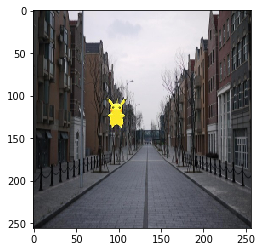

In [4]:
display(img, output, 0.1)

In [5]:
output

tensor([], size=(0, 6))